<a href="https://colab.research.google.com/github/trajinthan/Creditcard-Default-prediction/blob/master/XGBoost_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Python Package Dependencies**

In [0]:
# load numpy
import numpy as np

# load pandas for 
##   1. reading various files into the dataframe
##   2. to performa various data manipulation tasks
import pandas as pd

# load matplot lib for various plotting
import matplotlib.pyplot as plt   
%matplotlib inline

# for visually appealing plots
import seaborn as sns

# to use the Logit()
import statsmodels.api as sm

# for cross validation
from sklearn.model_selection import train_test_split

# for preprocessing
from sklearn.preprocessing import StandardScaler

# for various metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# load XGBoost library
import xgboost as xgb

# **Data Exploration**

**Data Set loading**

In [0]:
# loading csv files
traindata = pd.read_csv('credit_card_default_train.csv',sep=",")
testdata = pd.read_csv('credit_card_default_test.csv',sep=",")

In [0]:
# displaying training dataset
traindata.head()

,Client_ID,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
0,A2,1M,M,Graduate,Other,31-45,-1,-1,-1,-1,-1,-1,3248,3389,6004,39418,162772,-13982,3437,6004,39418,162772,0,538165,0
1,A3,1M,F,High School,Other,Less than 30,0,-1,-1,-1,-1,0,353351,151818,26948,43530,80811,124590,151818,46200,43530,80811,942,33666,0
2,A4,100K,F,High School,Single,31-45,4,3,2,2,-2,-2,16681,16082,15477,0,0,0,0,0,0,0,0,0,1
3,A5,200K,F,Graduate,Single,31-45,2,0,0,0,0,0,90457,92848,95193,97309,100353,102740,3855,3890,3696,4620,4049,3918,1
4,A6,1M,F,Graduate,Other,31-45,2,2,0,0,0,0,429556,419466,429785,435354,445271,453899,0,20790,16170,17325,16401,17325,0


**Looking into the data in depths and checking the Min, Max values, mean and the Standard Deviation**

In [0]:
traindata.describe()

,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,2.400000e+04,24000.000000,2.400000e+04,24000.000000
mean,-0.014208,-0.130042,-0.158667,-0.215542,-0.261167,-0.287667,1.188697e+05,1.140727e+05,1.092435e+05,1.003573e+05,9.377699e+04,9.034068e+04,1.330648e+04,1.386675e+04,1.209312e+04,1.122527e+04,11174.737208,1.230122e+04,0.222083
std,1.124897,1.200566,1.198875,1.166608,1.131855,1.147847,1.710424e+05,1.652414e+05,1.614737e+05,1.490071e+05,1.417389e+05,1.387237e+05,3.935742e+04,5.648588e+04,4.065924e+04,3.624693e+04,36040.821759,4.233848e+04,0.415656
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-3.824900e+05,-1.611850e+05,-1.420790e+05,-3.927000e+05,-1.878820e+05,-7.844830e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.246250e+03,6.968750e+03,6.238500e+03,5.429000e+03,4.179750e+03,2.913000e+03,2.310000e+03,1.956000e+03,9.010000e+02,6.930000e+02,610.000000,3.070000e+02,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.156850e+04,4.871700e+04,4.641150e+04,4.410500e+04,4.186300e+04,3.940900e+04,4.920000e+03,4.646500e+03,4.197000e+03,3.465000e+03,3465.000000,3.465000e+03,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.562745e+05,1.489050e+05,1.401622e+05,1.269750e+05,1.169262e+05,1.144352e+05,1.160500e+04,1.155000e+04,1.062600e+04,9.360000e+03,9411.500000,9.252500e+03,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2.228020e+06,2.272881e+06,3.844046e+06,2.059564e+06,2.141765e+06,2.221444e+06,2.017905e+06,3.890638e+06,2.069852e+06,1.434510e+06,965557.000000,1.221218e+06,1.000000


**Convert the datas into numerical data**

In [0]:
traindata = traindata.replace(['M','F'], [1,-1])
testdata = testdata.replace(['M','F'], [1,-1])

In [0]:
pd.to_numeric(traindata['Gender'])

0        1
1       -1
2       -1
3       -1
4       -1
        ..
23995   -1
23996   -1
23997   -1
23998   -1
23999   -1
Name: Gender, Length: 24000, dtype: int64

In [0]:
# to find the education_status categories
print(traindata.groupby('EDUCATION_STATUS').count()) 

                  Client_ID  Balance_Limit_V1  ...  PAID_AMT_DEC  NEXT_MONTH_DEFAULT
EDUCATION_STATUS                               ...                                  
Graduate               8478              8478  ...          8478                8478
High School            3925              3925  ...          3925                3925
Other                 11597             11597  ...         11597               11597

[3 rows x 24 columns]


In [0]:
traindata['EDUCATION_STATUS'] = traindata['EDUCATION_STATUS'].replace(['Graduate','High School','Other'], [2,1,0])
testdata['EDUCATION_STATUS'] = testdata['EDUCATION_STATUS'].replace(['Graduate','High School','Other'], [2,1,0])

In [0]:
pd.to_numeric(traindata['EDUCATION_STATUS'])

0        2
1        1
2        1
3        2
4        2
        ..
23995    1
23996    1
23997    0
23998    1
23999    0
Name: EDUCATION_STATUS, Length: 24000, dtype: int64

In [0]:
# to find the marital_status categories
print(traindata.groupby('MARITAL_STATUS').count())

                Client_ID  Balance_Limit_V1  ...  PAID_AMT_DEC  NEXT_MONTH_DEFAULT
MARITAL_STATUS                               ...                                  
Other               13070             13070  ...         13070               13070
Single              10930             10930  ...         10930               10930

[2 rows x 24 columns]


In [0]:
traindata['MARITAL_STATUS'] = traindata['MARITAL_STATUS'].replace(['Single', 'Other'], [1,-1])
testdata['MARITAL_STATUS'] = testdata['MARITAL_STATUS'].replace(['Single', 'Other'], [1,-1])

In [0]:
pd.to_numeric(traindata['EDUCATION_STATUS'])

0        2
1        1
2        1
3        2
4        2
        ..
23995    1
23996    1
23997    0
23998    1
23999    0
Name: EDUCATION_STATUS, Length: 24000, dtype: int64

In [0]:
# to find the age categories
print(traindata.groupby('AGE').count())

              Client_ID  Balance_Limit_V1  ...  PAID_AMT_DEC  NEXT_MONTH_DEFAULT
AGE                                        ...                                  
31-45             12124             12124  ...         12124               12124
46-65              4150              4150  ...          4150                4150
Less than 30       7638              7638  ...          7638                7638
More than 65         88                88  ...            88                  88

[4 rows x 24 columns]


In [0]:
traindata['AGE'] = traindata['AGE'].replace(['Less than 30','31-45','46-65','More than 65'], [4,3,2,1])
testdata['AGE'] = testdata['AGE'].replace(['Less than 30','31-45','46-65','More than 65'], [4,3,2,1])

In [0]:
traindata['Balance_Limit_V1'] = traindata['Balance_Limit_V1'].map(lambda x : float(x[0:-1])*1000 if (x[-1]=='K') else float(x[0:-1])*1000000)
testdata['Balance_Limit_V1'] = testdata['Balance_Limit_V1'].map(lambda x : float(x[0:-1])*1000 if (x[-1]=='K') else float(x[0:-1])*1000000)

In [0]:
pd.to_numeric(traindata['Balance_Limit_V1'])

0        1000000.0
1        1000000.0
2         100000.0
3         200000.0
4        1000000.0
           ...    
23995    1000000.0
23996     400000.0
23997     100000.0
23998     200000.0
23999     200000.0
Name: Balance_Limit_V1, Length: 24000, dtype: float64

In [0]:
print(traindata.groupby('NEXT_MONTH_DEFAULT').count())

                    Client_ID  Balance_Limit_V1  ...  PAID_AMT_NOV  PAID_AMT_DEC
NEXT_MONTH_DEFAULT                               ...                            
0                       18670             18670  ...         18670         18670
1                        5330              5330  ...          5330          5330

[2 rows x 24 columns]


In [0]:
traindata.groupby('NEXT_MONTH_DEFAULT').mean()

,Balance_Limit_V1,Gender,EDUCATION_STATUS,MARITAL_STATUS,AGE,PAY_JULY,PAY_AUG,PAY_SEP,PAY_OCT,PAY_NOV,PAY_DEC,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC
NEXT_MONTH_DEFAULT,,,,,,,,,,,,,,,,,,,,,,,
0,551756.829138,0.226781,0.888859,-0.104017,3.140225,-0.209159,-0.297161,-0.30557,-0.347938,-0.382860,-0.402410,120698.410284,115412.935672,110513.657900,101133.884574,94353.630905,90824.037493,14839.278790,15648.549330,13348.943867,12312.560900,12211.672523,13488.071130
1,407166.979362,0.128705,0.804128,-0.037148,3.130206,0.668668,0.455347,0.35591,0.248218,0.165103,0.114259,112464.222702,109378.238086,104794.528893,97636.900938,91757.125516,88647.583490,7937.380488,7625.417636,7694.211445,7416.694934,7542.545403,8143.887992


# **Exploratory Data Analysis**

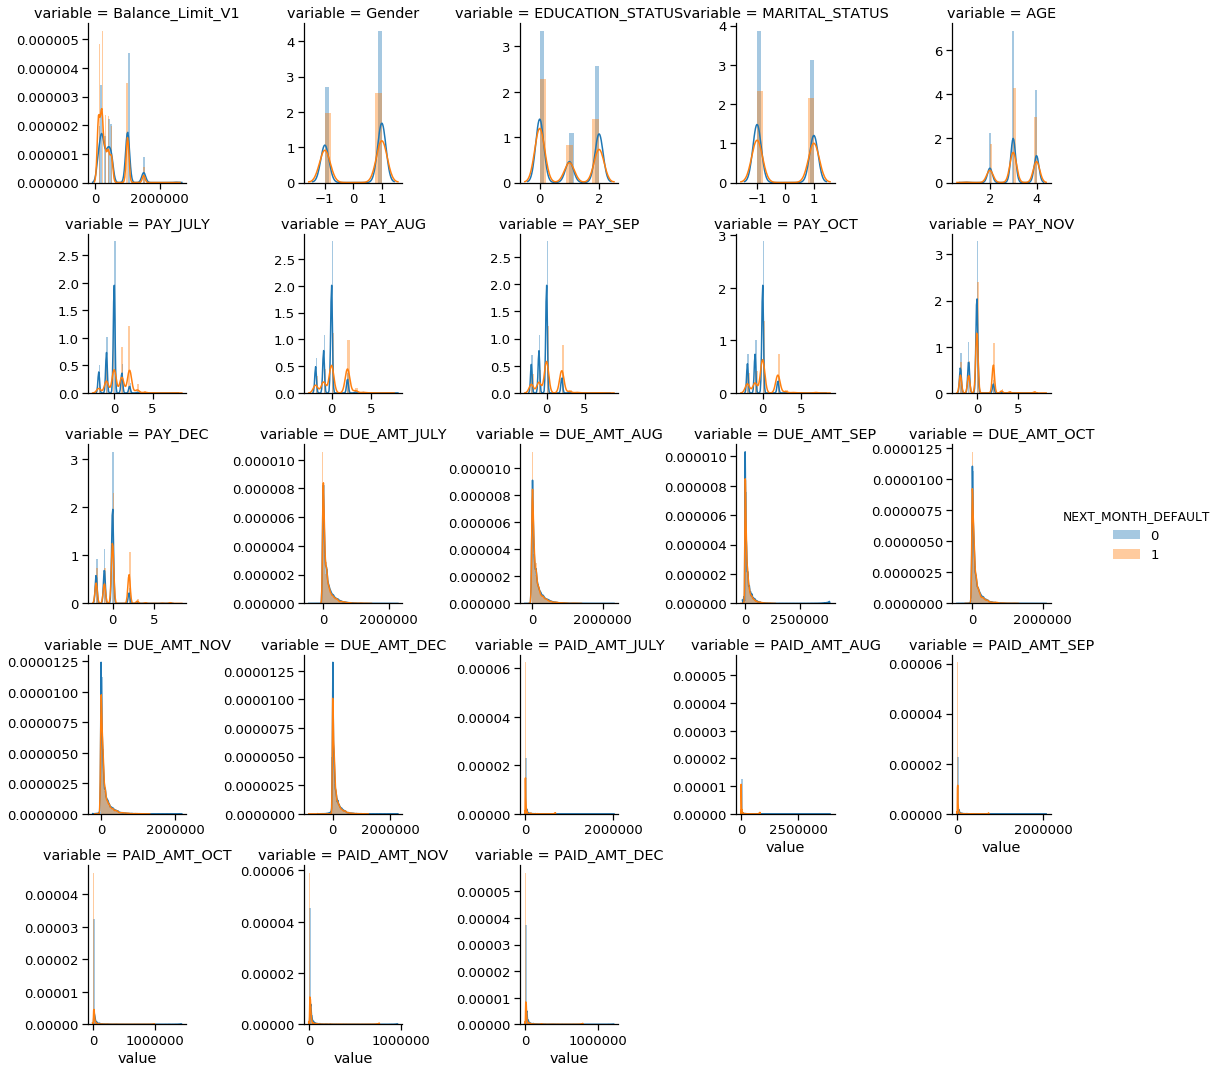

In [0]:
output = 'NEXT_MONTH_DEFAULT'

cols = [ f for f in traindata.columns if traindata.dtypes[ f ] != "object"]

cols.remove( output )

f = pd.melt( traindata, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=5, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

**Frequency of explanatory variables by defaulted and non-defaulted cards**

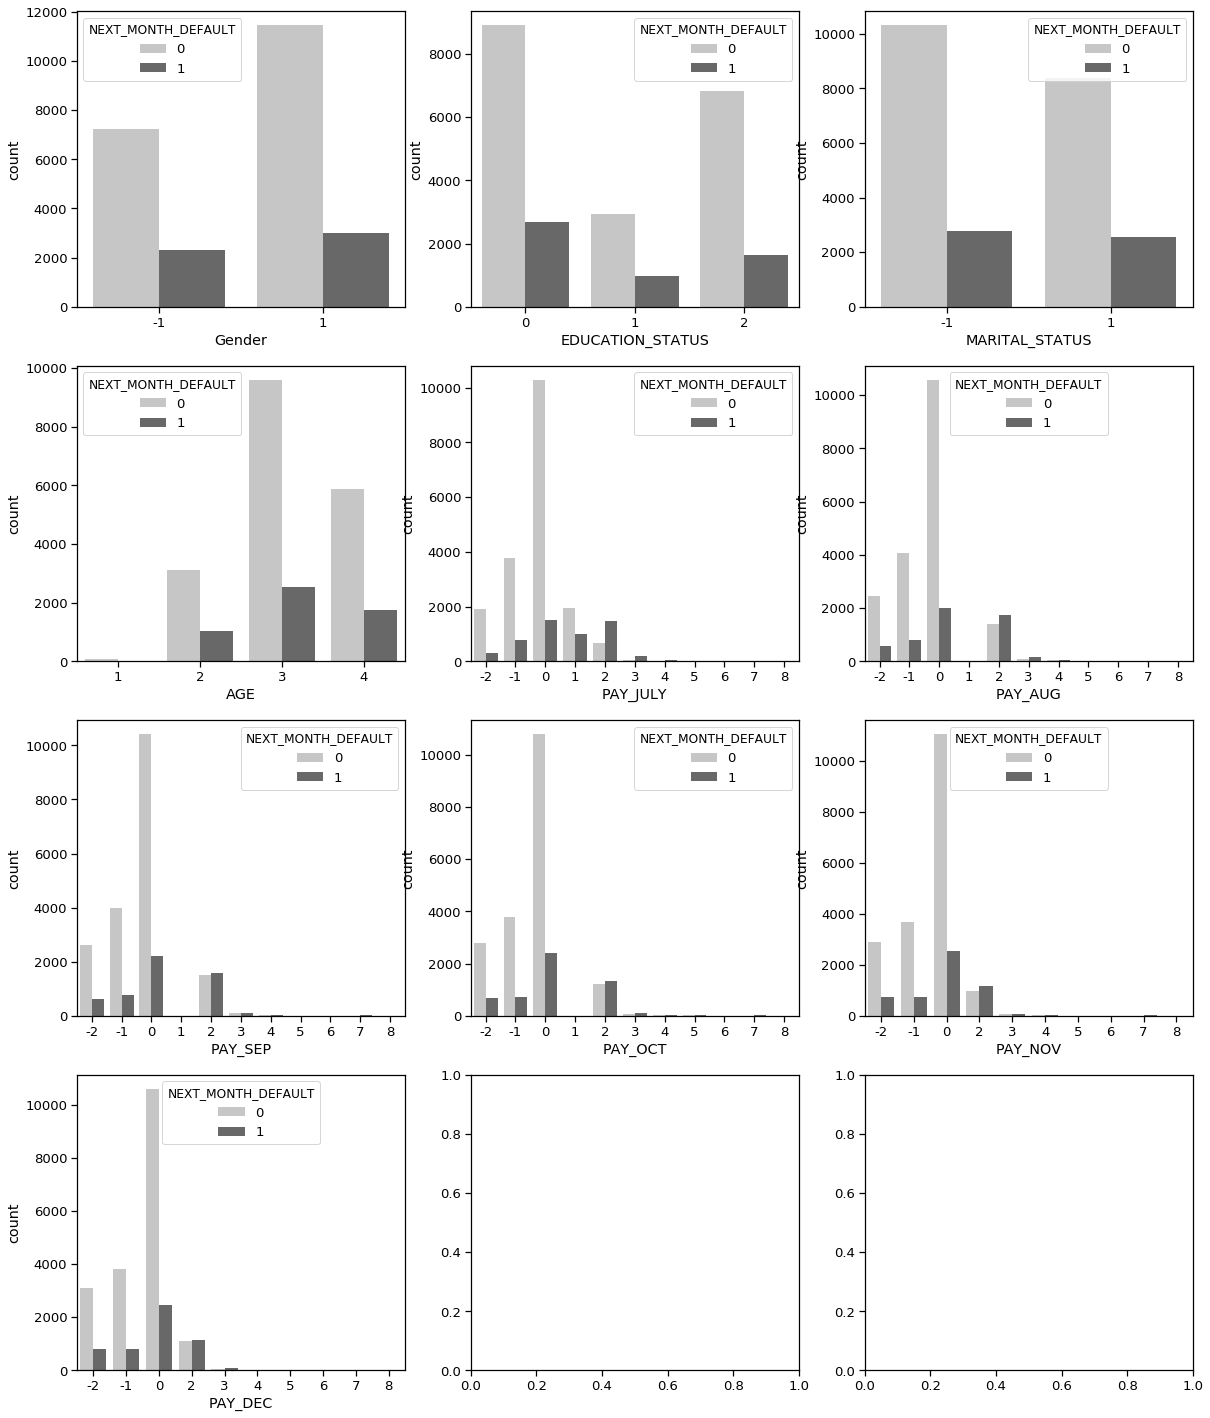

In [0]:
subset = traindata[['Gender', 'EDUCATION_STATUS', 'MARITAL_STATUS', 'AGE','PAY_JULY', 'PAY_AUG', 'PAY_SEP', 'PAY_OCT', 
               'PAY_NOV', 'PAY_DEC','NEXT_MONTH_DEFAULT']]

f, axes = plt.subplots(4, 3, figsize=(20, 25), facecolor='white')
ax1 = sns.countplot(x="Gender", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[0,0])
ax2 = sns.countplot(x="EDUCATION_STATUS", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys",ax=axes[0,1])
ax3 = sns.countplot(x="MARITAL_STATUS", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys",ax=axes[0,2])
ax4 = sns.countplot(x="AGE", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[1,0])
ax5 = sns.countplot(x="PAY_JULY", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[1,1])
ax6 = sns.countplot(x="PAY_AUG", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[1,2])
ax7 = sns.countplot(x="PAY_SEP", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[2,0])
ax8 = sns.countplot(x="PAY_OCT", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[2,1])
ax9 = sns.countplot(x="PAY_NOV", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[2,2])
ax10 = sns.countplot(x="PAY_DEC", hue="NEXT_MONTH_DEFAULT", data=subset, palette="Greys", ax=axes[3,0]);

**Balance Limit Diagram**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


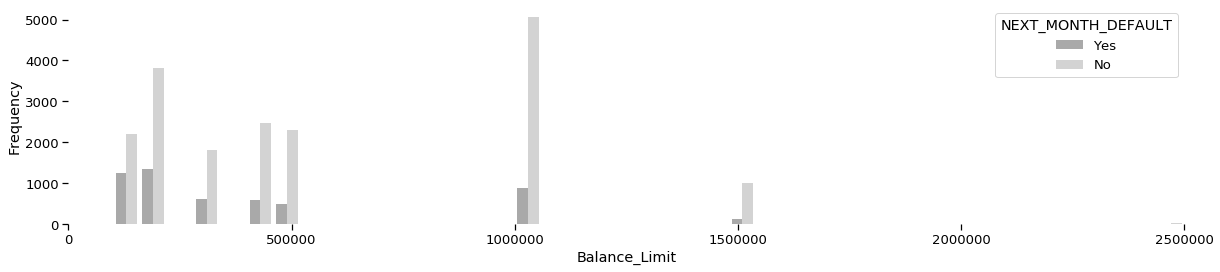

In [0]:
x1 = list(traindata[traindata['NEXT_MONTH_DEFAULT'] == 1]['Balance_Limit_V1'])
x2 = list(traindata[traindata['NEXT_MONTH_DEFAULT'] == 0]['Balance_Limit_V1'])

plt.figure(figsize=(20,4))
sns.set_context('notebook', font_scale=1.2)
plt.hist([x1, x2], bins = 40, normed=False, color=['darkgrey', 'lightgrey'])
plt.xlim([0,2500000])
plt.legend(['Yes', 'No'], title = 'NEXT_MONTH_DEFAULT', loc='upper right', facecolor='white')
plt.xlabel('Balance_Limit')
plt.ylabel('Frequency')
plt.box(False)

**Correlation**

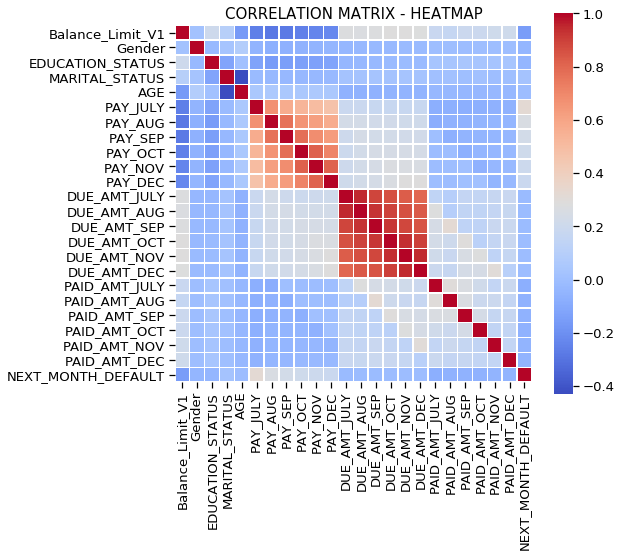

In [0]:
corr = traindata.corr()
f,ax = plt.subplots(figsize=(8, 7))
sns.heatmap(corr, cbar = True,  square = True, annot = False, fmt= '.1f', 
            xticklabels= True, yticklabels= True
            ,cmap="coolwarm", linewidths=.5, ax=ax)
plt.title('CORRELATION MATRIX - HEATMAP', size=15);

In [0]:
# testdata[testdata.columns[12:24]] = testdata[testdata.columns[12:24]]/traindata.max()[traindata.columns[12:24]]
# traindata[testdata1.columns[12:24]] = traindata[testdata.columns[12:24]]/traindata.max()[traindata.columns[12:24]]

In [0]:
# testdata['Balance_Limit_V1'] = testdata['Balance_Limit_V1']/traindata.max()['Balance_Limit_V1']
# traindata['Balance_Limit_V1'] = traindata['Balance_Limit_V1']/traindata.max()['Balance_Limit_V1']

In [0]:
traindata['BIAS'] = 1
testdata['BIAS'] = 1

In [0]:
independentVar= ['Balance_Limit_V1',
                'Gender',
                 'EDUCATION_STATUS',
                 'MARITAL_STATUS',
                #  'AGE',
                 'PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC',
                 'DUE_AMT_JULY','DUE_AMT_AUG','DUE_AMT_SEP','DUE_AMT_OCT','DUE_AMT_NOV','DUE_AMT_DEC',
                 'PAID_AMT_JULY','PAID_AMT_AUG','PAID_AMT_SEP','PAID_AMT_OCT','PAID_AMT_NOV','PAID_AMT_DEC',
                 'BIAS']

**Splitting the train data into 80% training data and 20% testing data**

In [0]:
train_data, test_data = train_test_split(traindata, train_size=0.8, test_size=0.2)
test_data_6000 = testdata

In [0]:
X_train, y_train = train_data[independentVar], train_data['NEXT_MONTH_DEFAULT']
X_test, y_test = test_data[independentVar], test_data['NEXT_MONTH_DEFAULT']
X_test_6000 = test_data_6000[independentVar]

In [0]:
# applying Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_6000 = scaler.transform(X_test_6000)

In [0]:
# from sklearn import metrics
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

In [0]:
# # define undersampling strategy
# under = RandomUnderSampler(sampling_strategy=0.3)

# # fit and apply the transform
# X_train_res, y_train_res = under.fit_resample(X_train, y_train)

# sm = SMOTE(random_state=2)
# X_train_res, y_train_res = sm.fit_sample(X_train_res, y_train_res.ravel())

# **Model Training**

In [0]:
# creating XGBoost classifier model object
model = xgb.XGBClassifier(learning_rate=0.01, 
                          n_estimators=200,
                          max_depth=3,
                          min_child_weight=5,
                          reg_alpha=0.005,
                          subsample=1,
                          objective='binary:logistic',
                          nthread=2,
                          colsample_bytree=0.8,
                          )

In [0]:
# fit the XGBoost model on the training dataset
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
              nthread=2, objective='binary:logistic', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# **Model Prediction**

### **Model Prediction for held out test data**

In [0]:
# make probability predictions with the model for held out test data
y_pred = model.predict(X_test)

**Analysis of Model Prediction for held out test data**

[[3559  155]
 [ 695  391]]


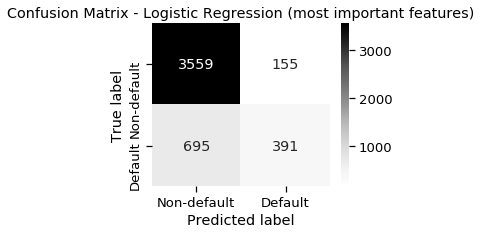

In [0]:
# Confusion matrix for held out test data

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

plt.figure(figsize=(4,3))

sns.heatmap(confusion_matrix, annot=True, cmap="Greys", fmt="d", 
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - Logistic Regression (most important features)");

In [0]:
# Classification report for held out test data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      3714
           1       0.72      0.36      0.48      1086

    accuracy                           0.82      4800
   macro avg       0.78      0.66      0.69      4800
weighted avg       0.81      0.82      0.80      4800



### **Model Prediction for 6000 test data**

In [0]:
# make probability predictions with the model for 6000 test data
y_pred_6000 = model.predict(X_test_6000)

In [0]:
# finding the count of zeros and ones from the model predictions obtained for 6000 test data

count_0 = 0
count_1 = 0

for val in y_pred_6000:
  if val == 0:
    count_0 += 1
  elif val == 1:
    count_1 += 1

print ("Count of 0s : " + str(count_0) + "\n" + "Count of 1s : " + str(count_1))

Count of 0s : 5349
Count of 1s : 651


**Exporting the model prediction for 6000 test data as CSV file**

In [0]:
output = pd.DataFrame(testdata['Client_ID'])
output['NEXT_MONTH_DEFAULT'] = y_pred_6000

output_csv = output.to_csv('xgboost_submission.csv')